## 1) Data Analysis

In [6]:
import torch
from pathlib import Path
from dataset import GraspDataset

# Create dataset
data_path = Path('data/processed')
dataset = GraspDataset(data_path)

# Get a single sample
sample = dataset[0]

# Print available keys
print("Sample contains the following keys:")
for key in sample.keys():
    print(f"- {key}")

# Print tensor shapes and data types
print("\nShapes:")
for key, tensor in sample.items():
    print(f"{key}: {tensor.shape}")

# Basic statistics for numerical tensors
print("\nBasic statistics:")
for key, tensor in sample.items():
    if torch.is_floating_point(tensor):
        print(f"{key}:")
        print(f"  Min: {tensor.min().item():.4f}")
        print(f"  Max: {tensor.max().item():.4f}")
        print(f"  Mean: {tensor.mean().item():.4f}")
        print(f"  Std: {tensor.std().item():.4f}")
        print()


Sample contains the following keys:
- sdf
- grasps
- scores

Shapes:
sdf: torch.Size([48, 48, 48])
grasps: torch.Size([480, 7])
scores: torch.Size([480])

Basic statistics:
sdf:
  Min: -0.7169
  Max: 1.4683
  Mean: 0.6416
  Std: 0.2782

grasps:
  Min: -0.5236
  Max: 1.8326
  Mean: 0.1521
  Std: 0.4945

scores:
  Min: -1.5000
  Max: 8.6819
  Mean: 1.6106
  Std: 2.8319



## 2) Overfitting on 1 sample

In [7]:
from pathlib import Path
from dataset import GraspDataset
from model import GQEstimator
import matplotlib.pyplot as plt
from tqdm import tqdm
import math

### 2.1) Initialize the model

In [8]:
# Initialize model and move to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

model = GQEstimator(
    input_size=48,
    base_channels=16,
    fc_dims=[256, 128, 64]
).to(device)

Using device: cpu
Initializing GQEstimator
Input size: 48
Flattened size: 3456
Number of parameters: 1218977


### 2.2) Get a small number of samples

In [9]:
# Create dataset
data_path = Path('data/processed')

dataset = GraspDataset(data_path)

scene = dataset[0]

def get_samples(scene, num_samples):
    # Get num_samples many unique indices
    indices = torch.randperm(len(scene['grasps']))[:num_samples]
    samples = []
    for i in indices:
        sample = {
            'grasps': scene['grasps'][i].float().to(device),
            'scores': scene['scores'][i].float().to(device),
            'sdf': scene['sdf'].float().to(device)
        }
        samples.append(sample)
    return samples

samples = get_samples(scene, 10)

for i, sample in enumerate(samples[:3]):
    print(f"Sample {i}:")
    print("\tgrasps: ", sample['grasps'].tolist())
    print("\tscore: ", sample['scores'].item())


print(samples[0]['grasps'].shape)
print(samples[0]['scores'].shape)
print(samples[0]['sdf'].shape)



Sample 0:
	grasps:  [-0.14973855018615723, -0.4954754710197449, 0.4909341335296631, -0.0407298319041729, -0.1630133092403412, 0.5009341835975647, -0.0955982506275177]
	score:  0.6014598608016968
Sample 1:
	grasps:  [1.8254671096801758, 0.019515162333846092, -0.3190658390522003, 0.09756720811128616, -0.5070078372955322, 0.2509341835975647, 0.43570056557655334]
	score:  -0.296999990940094
Sample 2:
	grasps:  [1.8254671096801758, 0.013246367685496807, -0.3490658402442932, 0.9402824640274048, 0.0366765633225441, 1.0318948030471802, 0.12721051275730133]
	score:  -1.5
torch.Size([7])
torch.Size([])
torch.Size([48, 48, 48])


### 2.3) Overfit on these samples from that one scene

[7.467961795674637, 7.464760744804517, 7.46210340638645, 7.459885980095715, 7.457702191639692, 7.455563902715221, 7.453464439790696, 7.451279206690378, 7.449333076179028, 7.447155543440021, 7.444989512069151, 7.442092266306281, 7.439235073467716, 7.436303801997565, 7.433306764136068, 7.4299659908749165, 7.426572826760821, 7.423071280587465, 7.419014762411825, 7.414272176870145, 7.409702169615775, 7.40385797204217, 7.3985545088013165, 7.392953398427926, 7.386128518930855, 7.379842883367838, 7.3708514354677845, 7.361000522777613, 7.349560379434843, 7.338317180075682, 7.3253641578019595, 7.313698591617867, 7.298248230991885, 7.282131543103605, 7.267710600048304, 7.2505417474545535, 7.234326729830355, 7.216762424074114, 7.202054835506715, 7.184714289727344, 7.1679052105479055, 7.151261020672973, 7.138387516769581, 7.124434551596641, 7.112075328547507, 7.1009881746023895, 7.090858816914261, 7.080819348990917, 7.072541110217571, 7.065455041080713, 7.059413346275687, 7.054255698248744, 7.0511

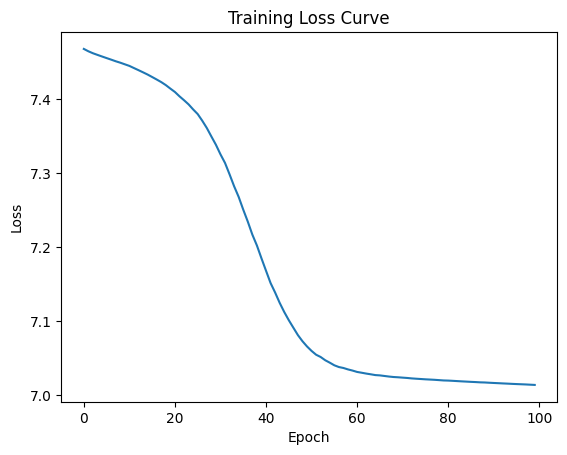

In [10]:
EPOCHS = 100

losses = []
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
criterion = torch.nn.MSELoss()

for epoch in range(EPOCHS):
    epoch_loss = 0.0
    for sample in samples:
        optimizer.zero_grad()
        sdf_features = model.encode_sdf(sample['sdf'])
        flattened_features = torch.cat([sdf_features, sample['grasps']])
        pred_quality = model(flattened_features)
        loss = criterion(pred_quality, sample['scores'])
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    epoch_loss /= len(samples)
    losses.append(epoch_loss)

print(losses)

plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.show()


## 3) Full Training

### 3.2) Create the datasets

In [11]:
import random

# Load the dataset
dataset = GraspDataset(data_path)

# Split dataset into training and validation
val_split = 0.2
num_samples = len(dataset)
train_size = int(num_samples * (1 - val_split))
val_size = num_samples - train_size

print(f"Subset samples: {num_samples}, Calculated train size: {train_size}, Calculated val size: {val_size}")

# Shuffle indices
random.seed(42)
indices = list(range(num_samples))
random.shuffle(indices)

# Split indices
train_indices = indices[:100]
val_indices = indices[-10:]

# Create Subsets
train_dataset = torch.utils.data.Subset(dataset, train_indices)
val_dataset = torch.utils.data.Subset(dataset, val_indices)

print(f"Train dataset size: {len(train_dataset)}, Validation dataset size: {len(val_dataset)}")

Subset samples: 15547, Calculated train size: 12437, Calculated val size: 3110
Train dataset size: 100, Validation dataset size: 10


In [1]:
import random
from pathlib import Path
from dataset import GraspDataset, GraspBatchIterableDataset
from model import GQEstimator
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch.utils.data import DataLoader, Subset
import torch

# --- Configuration ---
LEARNING_RATE = 1e-4
EPOCHS = 100
VAL_SPLIT = 0.2
BASE_CHANNELS = 4
FC_DIMS = [32, 16, 8]
SCENE_BATCH_SIZE = 1 # Process one scene at a time. Increase if you have lots of system RAM.
GRASP_BATCH_SIZE = 480 # Process all 480 grasps per scene at once. Reduce if you run out of VRAM.
NUM_WORKERS = 4
GRASP_BATCH_SIZE = 32

# --- Device Setup ---
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# --- Dataset and Dataloaders ---
data_path = Path('data/processed')
dataset = GraspDataset(data_path)

num_samples = len(dataset)
train_size = int(num_samples * (1 - VAL_SPLIT))
val_size = num_samples - train_size
print(f"Total scenes: {num_samples}, Train scenes: {train_size}, Val scenes: {val_size}")

indices = list(range(num_samples))
random.seed(42)
random.shuffle(indices)

train_indices = indices[:100]
val_indices = indices[-10:]

train_set = Subset(dataset, train_indices)
val_set = Subset(dataset, val_indices)
print(f"Train dataset size: {len(train_set)}, Validation dataset size: {len(val_set)}")

# Create the iterable datasets
train_grasp_dataset = GraspBatchIterableDataset(train_set, grasp_batch_size=GRASP_BATCH_SIZE, shuffle_scenes=True)
val_grasp_dataset = GraspBatchIterableDataset(val_set, grasp_batch_size=GRASP_BATCH_SIZE, shuffle_scenes=False)

# The dataloader now yields your desired batches directly!
# batch_size=None is important for iterable datasets that do their own batching.
pin_memory = torch.cuda.is_available()
train_loader = DataLoader(train_grasp_dataset, batch_size=None, num_workers=NUM_WORKERS, pin_memory=pin_memory, persistent_workers=True)
val_loader = DataLoader(val_grasp_dataset, batch_size=None, num_workers=NUM_WORKERS, pin_memory=pin_memory, persistent_workers=True)

# --- Model, Optimizer, Loss ---
model = GQEstimator(input_size=48, base_channels=BASE_CHANNELS, fc_dims=FC_DIMS).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = torch.nn.MSELoss()

# --- Training Loop ---
print(f"\nStarting training for {EPOCHS} epochs...")
for epoch in range(EPOCHS):
    model.train()
    total_train_loss = 0
    num_steps = 0

    for sdf, grasp_batch, score_batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS} Training"):
        
        optimizer.zero_grad()

        # Move to device
        sdf = sdf.to(device)
        grasp_batch = grasp_batch.to(device)
        score_batch = score_batch.to(device)

        # 1. Encode SDF
        sdf_features = model.encode_sdf(sdf)

        # 2. Expand features for the grasp batch
        expanded_sdf_features = sdf_features.expand(GRASP_BATCH_SIZE, -1)

        # 3. Concatenate features
        flattened_features = torch.cat([expanded_sdf_features, grasp_batch], dim=1)

        # 4. Predict grasp quality and compute loss
        pred_quality = model(flattened_features)
        loss = criterion(pred_quality, score_batch)
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item() * GRASP_BATCH_SIZE
        num_steps += GRASP_BATCH_SIZE

    avg_train_loss = total_train_loss / num_steps

    # --- Validation Loop ---
    model.eval()
    total_val_loss = 0
    num_steps = 0
    with torch.no_grad():
        for sdf, grasp_batch, score_batch in tqdm(val_loader, desc=f"Epoch {epoch+1}/{EPOCHS} Validation"):
            # Move to device
            sdf = sdf.to(device)
            grasp_batch = grasp_batch.to(device)
            score_batch = score_batch.to(device)

            # 1. Encode SDF
            sdf_features = model.encode_sdf(sdf)

            # 2. Expand features for the grasp batch
            expanded_sdf_features = sdf_features.expand(GRASP_BATCH_SIZE, -1)

            # 3. Concatenate features
            flattened_features = torch.cat([expanded_sdf_features, grasp_batch], dim=1)

            # 4. Predict grasp quality and compute loss
            pred_quality = model(flattened_features)
            loss = criterion(pred_quality, score_batch)

            total_val_loss += loss.item() * GRASP_BATCH_SIZE
            num_steps += GRASP_BATCH_SIZE


    avg_val_loss = total_val_loss / num_steps
    print(f'Epoch [{epoch+1}/{EPOCHS}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')

# --- Save Model ---
model_path = "model.pth"
torch.save(model.state_dict(), model_path)
print(f"Model saved successfully to {model_path}")

Using device: cpu
Total scenes: 15547, Train scenes: 12437, Val scenes: 3110
Train dataset size: 100, Validation dataset size: 10
Initializing GQEstimator
Input size: 48
Flattened size: 864
Number of parameters: 46889

Starting training for 100 epochs...


Epoch 1/100 Training: 1500it [00:12, 118.42it/s]
Epoch 1/100 Validation: 150it [00:03, 45.37it/s] 


Epoch [1/100], Train Loss: 1428.0676, Val Loss: 2157.5908


Epoch 2/100 Training: 1500it [00:09, 154.44it/s]
Epoch 2/100 Validation: 150it [00:00, 382.83it/s]


Epoch [2/100], Train Loss: 1227.8335, Val Loss: 2020.9217


Epoch 3/100 Training: 1500it [00:10, 149.67it/s]
Epoch 3/100 Validation: 150it [00:00, 372.34it/s]


Epoch [3/100], Train Loss: 1002.7648, Val Loss: 2210.7131


Epoch 4/100 Training: 1500it [00:09, 151.67it/s]
Epoch 4/100 Validation: 150it [00:00, 322.69it/s]


Epoch [4/100], Train Loss: 955.6939, Val Loss: 1957.2006


Epoch 5/100 Training: 1500it [00:09, 150.78it/s]
Epoch 5/100 Validation: 150it [00:00, 382.35it/s]


Epoch [5/100], Train Loss: 1144.3349, Val Loss: 1930.4105


Epoch 6/100 Training: 1500it [00:10, 147.35it/s]
Epoch 6/100 Validation: 150it [00:00, 365.09it/s]


Epoch [6/100], Train Loss: 1113.9512, Val Loss: 1864.8394


Epoch 7/100 Training: 1500it [00:10, 149.66it/s]
Epoch 7/100 Validation: 150it [00:00, 364.31it/s]


Epoch [7/100], Train Loss: 904.2107, Val Loss: 2259.5488


Epoch 8/100 Training: 1500it [00:10, 149.81it/s]
Epoch 8/100 Validation: 150it [00:00, 330.51it/s]


Epoch [8/100], Train Loss: 947.7450, Val Loss: 1749.8071


Epoch 9/100 Training: 243it [00:01, 141.70it/s]


KeyboardInterrupt: 